In [1]:
!pip install -U torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/da/ae/76bd3682465730dea7be21f36a8160a911a470de6f26228904f222e7fefe/torchvision-0.16.2-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torch==2.1.2 from https://files.pythonhosted.org/packages/03/f1/13137340776dd5d5bcfd2574c9c6dfcc7618285035cd77240496e5c1a79b/torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.2 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for nvidia-cudnn-cu12==8.9.2.26 from https://files.pythonhosted.org/packages/ff/74/a2e2be7fb83aaedec84f391f082cf765dfb635e7caa9b49065f73e4835d8/nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
print(torchvision.__version__)

0.16.2+cu121


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms ={
    'train': v2.Compose([
        v2.ToImage(),
        v2.Resize(528, antialias=True),
#         v2.RandomRotation(45),
#         v2.RandomRotation(180),
#         v2.RandomRotation(30),
#         v2.RandomPosterize(bits=2),
#         v2.RandomAdjustSharpness(sharpness_factor=2),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.ColorJitter(brightness=[0.5, 1.5]),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.Resize(528, antialias=True),
        # v2.CenterCrop(size=(224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = '/kaggle/input/dataset-granules'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

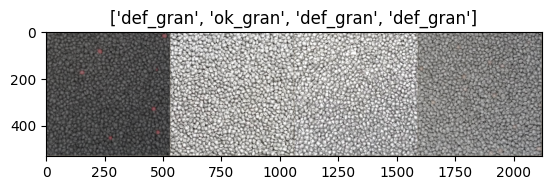

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
plt.figure(figsize=[20, 20])
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.imshow(out, title=[class_names[x] for x in classes])

In [14]:
data_transforms_test ={
    'test': v2.Compose([
        v2.ToImage(),
        v2.Resize(528, antialias=True),
        # v2.CenterCrop(size=(224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

In [15]:
data_dir_test = '/kaggle/input/test-dataset'

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir_test, x),
                                          data_transforms_test[x])
                  for x in ['test']}

dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x], batch_size=4,
                                             shuffle=True, num_workers=2)
                   for x in ['test']}

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc: #   or epoch_loss < best_loss
                    best_acc = epoch_acc
                    # best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)
            PATH = f'/kaggle/working/model_{epoch}.pth'
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler': scheduler,}, PATH)


        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')        

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        torch.save(model.state_dict(), '/kaggle/working/best_model_params_EFFICIENTNET_B6.pth')
    return model

In [10]:
from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [11]:
model_ft = models.efficientnet_b6(weights=EfficientNet_B6_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.

model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.007)

# Decay LR by a factor of 0.5 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.3)

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:01<00:00, 166MB/s]  


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
train Loss: 0.7957 Acc: 0.4905
val Loss: 0.7029 Acc: 0.4949
Epoch 1/11
----------
train Loss: 0.7800 Acc: 0.5024
val Loss: 0.7201 Acc: 0.5051
Epoch 2/11
----------
train Loss: 0.7701 Acc: 0.4941
val Loss: 0.8985 Acc: 0.4915
Epoch 3/11
----------
train Loss: 0.3884 Acc: 0.8004
val Loss: 0.0581 Acc: 0.9842
Epoch 4/11
----------
train Loss: 0.1283 Acc: 0.9603
val Loss: 0.0847 Acc: 0.9746
Epoch 5/11
----------
train Loss: 0.0804 Acc: 0.9768
val Loss: 0.0503 Acc: 0.9881
Epoch 6/11
----------
train Loss: 0.0487 Acc: 0.9873
val Loss: 0.0148 Acc: 0.9966
Epoch 7/11
----------
train Loss: 0.0451 Acc: 0.9891
val Loss: 0.0111 Acc: 0.9977
Epoch 8/11
----------
train Loss: 0.0399 Acc: 0.9891
val Loss: 0.0164 Acc: 0.9972
Epoch 9/11
----------
train Loss: 0.0303 Acc: 0.9928
val Loss: 0.0102 Acc: 0.9972
Epoch 10/11
----------
train Loss: 0.0281 Acc: 0.9924
val Loss: 0.0089 Acc: 0.9972
Epoch 11/11
----------
train Loss: 0.0264 Acc: 0.9939
val Loss: 0.0069 Acc: 0.9977
Training compl

In [16]:
import os
from pathlib import Path

data_path = Path("/kaggle/working/")

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

In [17]:
walk_through_dir(data_path)

There are 1 directories and 9 files in '/kaggle/working'.
There are 0 directories and 0 files in '/kaggle/working/.virtual_documents'.


### Train and evaluate





In [18]:
import os
os.chdir(r'/kaggle/working')

In [24]:
from IPython.display import FileLink
FileLink(r'grans_cpu.pth')

/kaggle/working/pipes_cpu.pth

In [13]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred, y_test = get_predictions(model_ft, dataloaders_test['test'])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

    def_gran       0.99      1.00      1.00       192
     ok_gran       1.00      0.99      1.00       143

    accuracy                           1.00       335
   macro avg       1.00      1.00      1.00       335
weighted avg       1.00      1.00      1.00       335



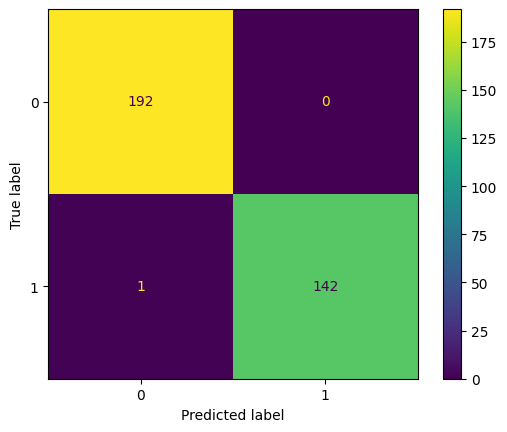

In [17]:
target_names = ['def_gran', 'ok_gran']
conf_matrix = classification_report(y_pred, y_test, target_names=target_names) #
print(conf_matrix)

cm = confusion_matrix(y_pred, y_test)
ConfusionMatrixDisplay(cm).plot()

In [18]:
model_path = 'best_model_params_EFFICIENTNET_B6.pth'
model_ft.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) #

<All keys matched successfully>

In [19]:
torch.save(model_ft, '/kaggle/working/grans_cpu.pth')